In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [145]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import movie_reviews
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc

nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [12]:
# Access the movie reviews and labels
documents = [(list(movie_reviews.words(fileid)), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]

In [17]:
random.shuffle(documents)

In [20]:
print("Sample Review:", documents[0][0][:10]) # Displaying the first 10 words for brevity
print("Label:", documents[0][1])

Sample Review: ['what', 'hath', 'kevin', 'williamson', 'wrought', '?', 'while', 'the', 'horror', 'movie']
Label: neg


In [18]:
df = pd.DataFrame(documents, columns=['words', 'category'])

In [19]:
df.head()

words category
0  [what, hath, kevin, williamson, wrought, ?, wh...      neg
1  [", easely, one, of, the, worst, films, of, th...      neg
2  [well, arnold, has, completed, the, seemingly,...      neg
3  [capsule, :, a, wild, jungle, woman, and, an, ...      neg
4  [jerry, springer, has, got, nothing, on, ", wi...      pos

In [21]:
df['review_length'] = df['words'].apply(len)

In [22]:
df.head()

words category  review_length
0  [what, hath, kevin, williamson, wrought, ?, wh...      neg            829
1  [", easely, one, of, the, worst, films, of, th...      neg            839
2  [well, arnold, has, completed, the, seemingly,...      neg            953
3  [capsule, :, a, wild, jungle, woman, and, an, ...      neg            306
4  [jerry, springer, has, got, nothing, on, ", wi...      pos            994

In [35]:
df['category'].value_counts()

category
neg    1000
pos    1000
Name: count, dtype: int64

In [23]:
df['review_length'].describe()

count    2000.000000
mean      791.910000
std       347.338096
min        19.000000
25%       560.000000
50%       745.000000
75%       957.250000
max      2879.000000
Name: review_length, dtype: float64

In [24]:
df['words'].describe()

count                                                  2000
unique                                                 2000
top       [what, hath, kevin, williamson, wrought, ?, wh...
freq                                                      1
Name: words, dtype: object

In [25]:
df['category'].describe()

count     2000
unique       2
top        neg
freq      1000
Name: category, dtype: object

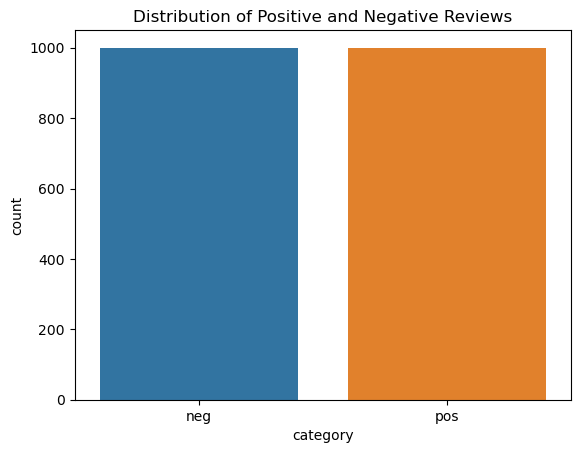

In [27]:
sns.countplot(x='category', data=df)
plt.title('Distribution of Positive and Negative Reviews')
plt.show()

Dataset is equally balanced

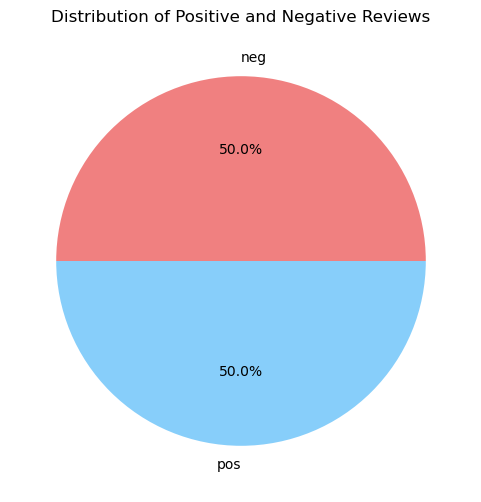

In [28]:
plt.figure(figsize=(6, 6))
df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Positive and Negative Reviews')
plt.ylabel('')
plt.show()

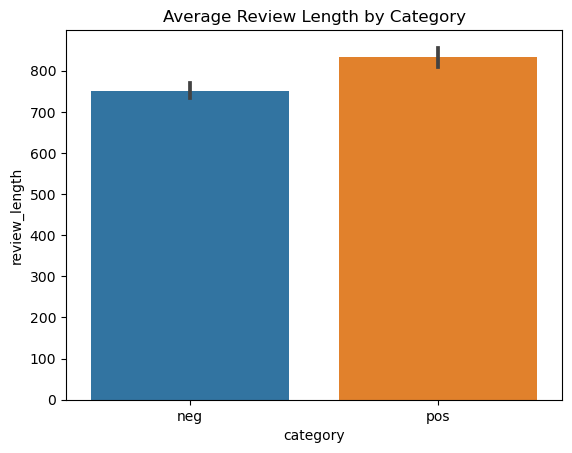

In [30]:
# Check the average length of reviews in each category
df['review_length'] = df['words'].apply(len)
sns.barplot(x='category', y='review_length', data=df)
plt.title('Average Review Length by Category')
plt.show()

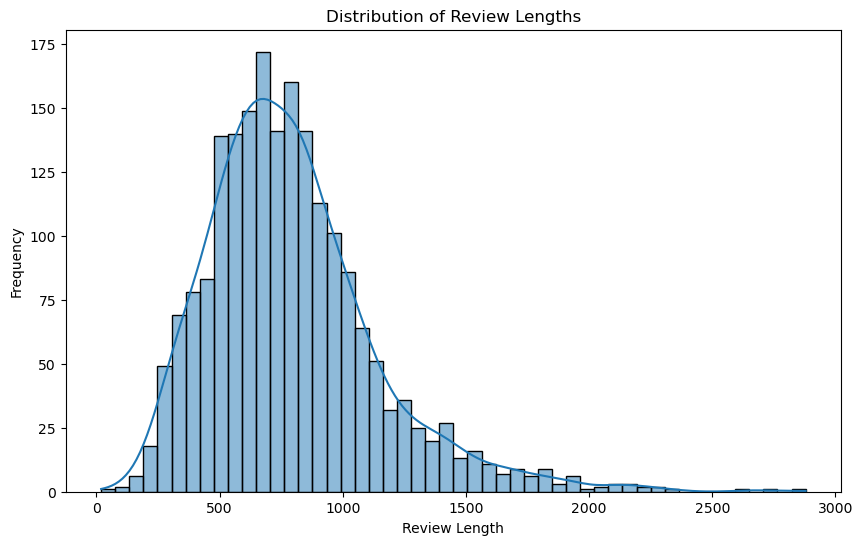

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [36]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...


True

In [42]:
def preprocess_text(words, use_lemmatization=True):
    # Convert the list of words to a string
    text = ' '.join(words)

    # Tokenization
    words = word_tokenize(text)

    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalnum()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming or lemmatization
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    else:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    return words

1. Applying preprocessing techniques including Tokenization and Lemmatization as shown above, and storing the processed words in the originial dataframe as shown below

In [45]:
df['processed_words'] = df['words'].apply(lambda x: preprocess_text(x))

In [44]:
# Display the preprocessed dataset
print(df[['words', 'processed_words', 'category']].head())

                                               words  \
0  [what, hath, kevin, williamson, wrought, ?, wh...   
1  [", easely, one, of, the, worst, films, of, th...   
2  [well, arnold, has, completed, the, seemingly,...   
3  [capsule, :, a, wild, jungle, woman, and, an, ...   
4  [jerry, springer, has, got, nothing, on, ", wi...   

                                     processed_words category  
0  [hath, kevin, williamson, wrought, horror, mov...      neg  
1  [easely, one, worst, film, year, millenium, ar...      neg  
2  [well, arnold, completed, seemingly, impossibl...      neg  
3  [capsule, wild, jungle, woman, 11, story, gori...      neg  
4  [jerry, springer, got, nothing, wild, thing, j...      pos  


In [46]:
coverage_analysis = []

for i in range(100, 1101, 100):
    subset_words = df['processed_words'].apply(lambda x: x[:i]).explode().unique()
    coverage_percentage = len(subset_words) / len(df['processed_words'].explode().unique()) * 100
    coverage_analysis.append((i, coverage_percentage))

In [47]:
coverage_df = pd.DataFrame(coverage_analysis, columns=['Number of Tokens', 'Coverage Percentage'])

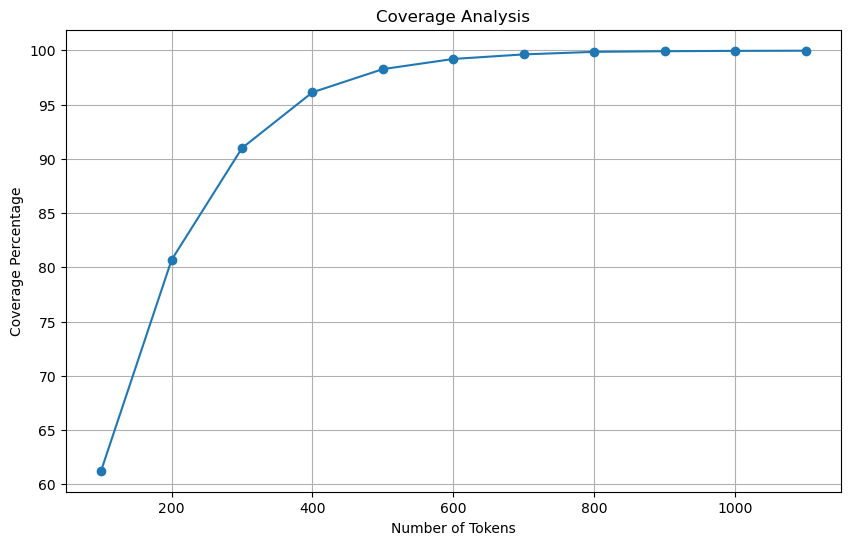

In [48]:
# Plotting the coverage analysis
plt.figure(figsize=(10, 6))
plt.plot(coverage_df['Number of Tokens'], coverage_df['Coverage Percentage'], marker='o')
plt.title('Coverage Analysis')
plt.xlabel('Number of Tokens')
plt.ylabel('Coverage Percentage')
plt.grid(True)
plt.show()

1. How does the coverage change with the number of tokens considered?

Early on, with a small number of tokens, the coverage percentage tends to increase rapidly. As more tokens are considered, the coverage continues to increase, but the rate of increase has been decreased.

2. At what point does the coverage seem to stabilize?

The point at which the coverage percentage starts to stabilize can be identified on the plot. After 600 tokens, adding more tokens does not lead to a substantial increase in coverage. 

3. Are there diminishing returns in terms of coverage as the number of tokens increases?
Diminishing returns can be observed in the plot when the slope of the curve starts to flatten i.e., after 600 tokens.


In [97]:
df['processed_text'] = df['processed_words'].apply(' '.join)

In [98]:
df.head()

words category  review_length  \
0  [what, hath, kevin, williamson, wrought, ?, wh...      neg            829   
1  [", easely, one, of, the, worst, films, of, th...      neg            839   
2  [well, arnold, has, completed, the, seemingly,...      neg            953   
3  [capsule, :, a, wild, jungle, woman, and, an, ...      neg            306   
4  [jerry, springer, has, got, nothing, on, ", wi...      pos            994   

                                     processed_words  \
0  [hath, kevin, williamson, wrought, horror, mov...   
1  [easely, one, worst, film, year, millenium, ar...   
2  [well, arnold, completed, seemingly, impossibl...   
3  [capsule, wild, jungle, woman, 11, story, gori...   
4  [jerry, springer, got, nothing, wild, thing, j...   

                                                text  \
0  hath kevin williamson wrought horror movie rev...   
1  easely one worst film year millenium around co...   
2  well arnold completed seemingly impossible tas...   
3  capsule wild jungle woman 11 story gorilla dis...   
4  jerry springer got nothing wild thing john mcn...   

                                      processed_text  
0  hath kevin williamson wrought horror movie rev...  
1  easely one worst film year millenium around co...  
2  well arnold completed seemingly impossible tas...  
3  capsule wild jungle woman 11 story gorilla dis...  
4  jerry springer got nothing wild thing john mcn...

In [99]:
train_data, test_data, train_labels, test_labels = train_test_split(df['processed_text'], df['category'], test_size=0.2, random_state=42)

In [100]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(train_data)
tfidf_test = tfidf_vectorizer.transform(test_data)

In [101]:
# Count Vectorizer (TF)
tf_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(train_data)
tf_test = tf_vectorizer.transform(test_data)

In [111]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_data, test_data, train_labels, test_labels, label):
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)
    
     # Evaluating performance
    acc = accuracy_score(test_labels, predictions)
    report = classification_report(test_labels, predictions)
    
    # Confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    
    # True Positive Rate (TPR)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate
    
    # False Positive Rate (FPR)
    fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])  # False Positive Rate
    
    print(f"{label} Accuracy: {acc}")
    print(f"{label} Classification Report:\n{report}")
    print(f"{label} True Positive Rate (TPR): {tpr}")
    print(f"{label} False Positive Rate (FPR): {fpr}")
    print(f"----------------------------------------")
    
    # Return metrics
    return {
        'accuracy': acc,
        'classification_report': report,
        'confusion_matrix': cm,
        'true_positive_rate': tpr,
        'false_positive_rate': fpr
    }   

In [139]:
# Train and evaluate Naive Bayes
nb_tfidf_pred = train_and_evaluate(MultinomialNB(), tfidf_train, tfidf_test, train_labels, test_labels, "Naive Bayes (TF-IDF)")
nb_tf_pred = train_and_evaluate(MultinomialNB(), tf_train, tf_test, train_labels, test_labels, "Naive Bayes (TF)")

# Train and evaluate Logistic Regression
lr_tfidf_pred = train_and_evaluate(LogisticRegression(max_iter=1000), tfidf_train, tfidf_test, train_labels, test_labels, "Logistic Regression (TF-IDF)")
lr_tf_pred = train_and_evaluate(LogisticRegression(max_iter=1000), tf_train, tf_test, train_labels, test_labels, "Logistic Regression (TF)")

# Train and evaluate MLP with three different layers
mlp_tfidf_pred_0 = train_and_evaluate(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000), tfidf_train, tfidf_test, train_labels, test_labels, "MLP (TF-IDF)")
mlp_tf_pred_0 = train_and_evaluate(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000), tf_train, tf_test, train_labels, test_labels, "MLP (TF)")

mlp_tfidf_pred_1 = train_and_evaluate(MLPClassifier(hidden_layer_sizes= (50, 50), max_iter=1000), tfidf_train, tfidf_test, train_labels, test_labels, "MLP (TF-IDF)")
mlp_tf_pred_1 = train_and_evaluate(MLPClassifier(hidden_layer_sizes= (50, 50), max_iter=1000), tf_train, tf_test, train_labels, test_labels, "MLP (TF)")

mlp_tfidf_pred_2 = train_and_evaluate(MLPClassifier(hidden_layer_sizes= (30, 20, 10), max_iter=1000), tfidf_train, tfidf_test, train_labels, test_labels, "MLP (TF-IDF)")
mlp_tf_pred_2 = train_and_evaluate(MLPClassifier(hidden_layer_sizes= (30, 20, 10), max_iter=1000), tf_train, tf_test, train_labels, test_labels, "MLP (TF)")


Naive Bayes (TF-IDF) Accuracy: 0.82
Naive Bayes (TF-IDF) Classification Report:
              precision    recall  f1-score   support

         neg       0.77      0.87      0.82       187
         pos       0.87      0.77      0.82       213

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400

Naive Bayes (TF-IDF) True Positive Rate (TPR): 0.7746478873239436
Naive Bayes (TF-IDF) False Positive Rate (FPR): 0.12834224598930483
----------------------------------------
Naive Bayes (TF) Accuracy: 0.8225
Naive Bayes (TF) Classification Report:
              precision    recall  f1-score   support

         neg       0.79      0.84      0.82       187
         pos       0.85      0.81      0.83       213

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Naive Bayes (TF) 

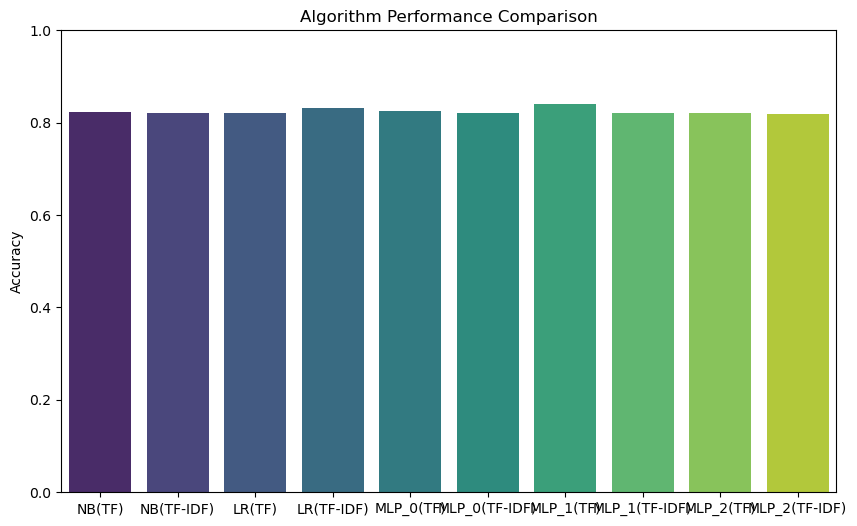

In [143]:
# Creating a list of algorithms and their corresponding accuracy valuesalgorithms = ["NB(TF)", "NB(TF-IDF)", "LR(TF)", "LR(TF-IDF)", "MLP_0(TF)", "MLP_0(TF-IDF)", "MLP_1(TF)", "MLP_1(TF-IDF)","MLP_2(TF)", "MLP_2(TF-IDF)"]
accuracy_values = [nb_tf_pred['accuracy'], nb_tfidf_pred['accuracy'], lr_tf_pred['accuracy'], lr_tfidf_pred['accuracy'], mlp_tf_pred_0['accuracy'], mlp_tfidf_pred_0['accuracy'],mlp_tf_pred_1['accuracy'],mlp_tfidf_pred_1['accuracy'],mlp_tf_pred_2['accuracy'],mlp_tfidf_pred_2['accuracy']]

# Creating a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=algorithms, y=accuracy_values, palette="viridis")
plt.title("Algorithm Performance Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)  # Assuming accuracy values are between 0 and 1
plt.show()


In comparing the performance of Naive Bayes (NB), Logistic Regression (LR), and Multi-Layer Perceptron (MLP) across different configurations, it is evident that MLP consistently demonstrates accuracy across both TF (Term Frequency) and TF-IDF (Term Frequency-Inverse Document Frequency) representations.

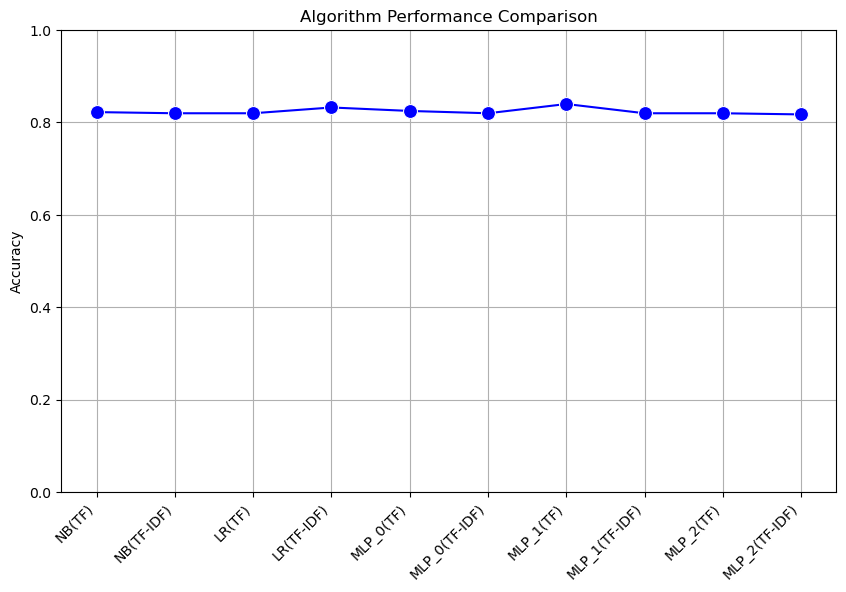

In [141]:
# Creating a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=algorithms, y=accuracy_values, marker='o', linestyle='-', markersize=10, color='b')
plt.title("Algorithm Performance Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)  # Assuming accuracy values are between 0 and 1
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

Specifically, for MLP with hidden layer configurations of (100,), (50,50), and (30,20,10), the accuracies range from 0.8175 to 0.84. 


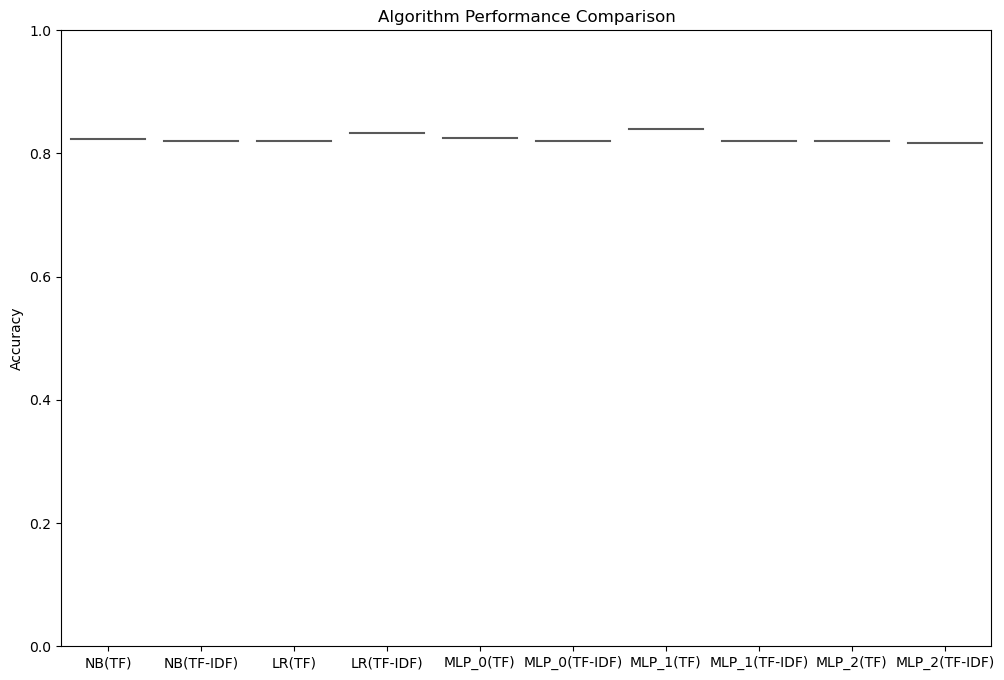

In [142]:
# Creating a violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x=algorithms, y=accuracy_values, palette="Set2")
plt.title("Algorithm Performance Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()